# **Reproduce P1.XNet - UTS**

Paper: https://paperswithcode.com/paper/xnet-a-convolutional-neural-network-cnn

XNet Model: https://github.com/JosephPB/XNet

Dataset: https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

Notebook: https://www.kaggle.com/code/pezhmansamadi/resu-net-retrain/notebook

In [1]:
!pip install -q mlflow

## Modul

In [2]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Dataset
### Montgomery and Shenzhen for train
https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

In [3]:
image_path_train = '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/'
mask_path_train = '../input/chest-xray-masks-and-labels/Lung Segmentation/masks/'
image_path_test = '../input/chest-xray-masks-and-labels/Lung Segmentation/test/' 

In [4]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:", len(check))
testing_files = set(os.listdir(image_path_train)) & set(os.listdir(mask_path_train))
training_files = check

Total mask that has modified name: 566


## Preparing Dataset

In [6]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "test":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "train":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i.split("_mask")[0] + ".png"), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i + ".png"), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
    # return list
    return im_array, mask_array

In [7]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, shape)
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

# Loading images and masks

In [8]:
dim, n_samples = 256, 50 # n_samples = [1, 96]

image_train, mask_train = getData(dim, flag = "train")
image_test, mask_test = getData(dim, flag = "test")
X_test = get_test(dim, n_samples = n_samples)

100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


In [9]:
image_train = np.array(image_train).reshape(len(image_train), dim, dim, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), dim, dim, 1)

image_test = np.array(image_test).reshape(len(image_test), dim, dim, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), dim, dim, 1)

X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

In [10]:
print(image_train.shape, mask_train.shape)
print(image_test.shape, mask_test.shape)
print(X_test.shape)

(566, 256, 256, 1) (566, 256, 256, 1)
(138, 256, 256, 1) (138, 256, 256, 1)
(50, 256, 256, 1)


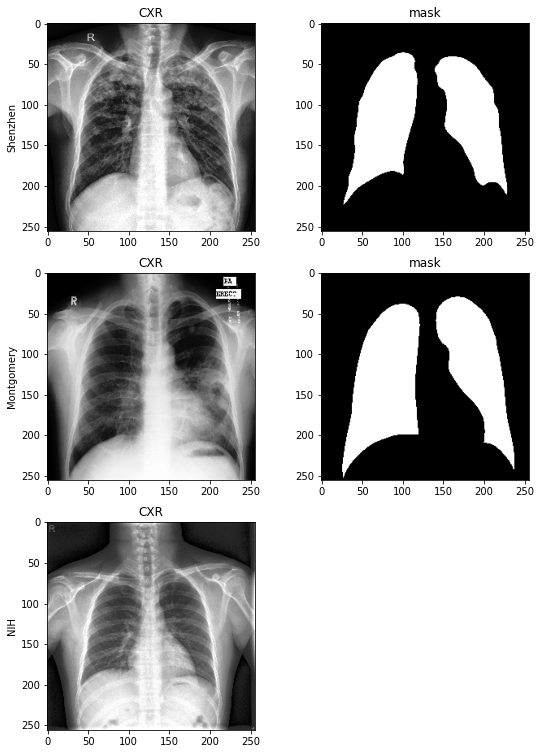

In [11]:
i = 25
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(image_train[i], cmap='gray')
axs[0, 1].imshow(mask_train[i], cmap='gray')
axs[0, 0].set_ylabel('Shenzhen')

axs[1, 0].imshow(image_test[i], cmap='gray')
axs[1, 1].imshow(mask_test[i], cmap='gray')
axs[1, 0].set_ylabel('Montgomery')

axs[2, 0].imshow(X_test[i], cmap='gray')
axs[2, 0].set_ylabel('NIH')

axs[0, 0].set_title('CXR')
axs[1, 0].set_title('CXR')
axs[2, 0].set_title('CXR')

axs[0, 1].set_title('mask')
axs[1, 1].set_title('mask')

fig.delaxes(axs[2, 1])

In [12]:
assert image_train.shape == mask_train.shape
assert image_test.shape == mask_test.shape
images = np.concatenate((image_train, image_test), axis=0)
masks  = np.concatenate((mask_train, mask_test), axis=0)

print(images.shape, masks.shape)

(704, 256, 256, 1) (704, 256, 256, 1)


# Data Augmetation
**create_contrast_images_v1**

In [13]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255.0
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [14]:
def create_contrast_images_v1(b, c):
    contrast_images = []
    for i in tqdm(range(len(images)), "contrast_images"):
        contrast_images.append(apply_brightness_contrast(images[i], brightness=b, contrast=c))
    return contrast_images

In [15]:
b, c = -40, -120

contrast_images_v1 = create_contrast_images_v1(b, c)
contrast_images_v1 = np.array(contrast_images_v1).reshape(len(contrast_images_v1), 256, 256, 1)
print(f'\nshape = {contrast_images_v1.shape}')

contrast_images: 100%|██████████| 704/704 [00:00<00:00, 19969.36it/s]


shape = (704, 256, 256, 1)


**create_contrast_images_v2**

In [16]:
def create_contrast_images_v2(alpha, beta):
    contrast_images_v2 = []
    for i in tqdm(range(len(images)), "contrast_images"):
        contrast_images_v2.append(cv2.addWeighted(images[i], alpha, images[i], 0, beta))
    return contrast_images_v2

In [17]:
alpha = 1.5 #@alpha
beta = 0.7 #@beta

contrast_images_v2 = create_contrast_images_v2(alpha, beta)
contrast_images_v2 = np.array(contrast_images_v2).reshape(len(contrast_images_v2), 256, 256, 1)
print(f'\nshape = {contrast_images_v2.shape}')

contrast_images: 100%|██████████| 704/704 [00:00<00:00, 44483.13it/s]


shape = (704, 256, 256, 1)


**create_noise_images**

In [18]:
def noise(i: int = len(images)):
    return np.random.randint(0, 255, size=(i, 256, 256, 1))

def noise_images(epsilon: float = 0.1):
    noised = noise()
    noised_img = []
    for i in tqdm(range(len(images)), "noise_images"):
        noised_img.append(noised[i] * epsilon + images[i])
    
    return noised_img

noised_images = noise_images(epsilon=0.1)
noised_images = np.array(noised_images).reshape(len(noised_images), 256, 256, 1)
print(f'\nshape = {noised_images.shape}')

noise_images: 100%|██████████| 704/704 [00:00<00:00, 2498.89it/s]



shape = (704, 256, 256, 1)


**Check images**

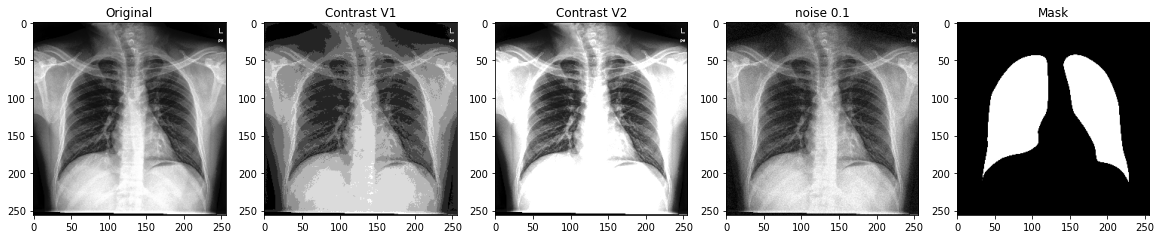

In [19]:
i = 15
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))

ax1.imshow(images[i].reshape(256, 256), cmap='gray')
ax1.set_title('Original')

ax2.imshow(contrast_images_v1[i].reshape(256, 256), cmap='gray')
ax2.set_title('Contrast V1')

ax3.imshow(contrast_images_v2[i].reshape(256, 256), cmap='gray')
ax3.set_title('Contrast V2')

ax4.imshow(noised_images[i].reshape(256, 256), cmap='gray')
ax4.set_title('noise 0.1')

ax5.imshow(masks[i].reshape(256, 256), cmap='gray')
ax5.set_title('Mask');

In [20]:
all_images = np.concatenate((images, contrast_images_v1, contrast_images_v2, noised_images), axis=0)
all_masks  = np.concatenate((masks, masks, masks, masks), axis=0)

In [21]:
all_images.shape, all_masks.shape

((2816, 256, 256, 1), (2816, 256, 256, 1))

In [22]:
# image size = (256 x 256)
X_train, X_val, Y_train, Y_val = train_test_split((all_images - 127.0) / 127.0, 
                                                  (all_masks > 127).astype(np.float32), 
                                                  test_size = 0.2, 
                                                  random_state = 2018)
X_testNorm = (X_test - 127.0) / 127.0

## Model

In [23]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import mlflow
import mlflow.tensorflow

2022-04-10 15:51:04.549437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [24]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred) 

In [25]:
def XNet(input_shape=(256,256,1), classes=1, kernel_size = 3, filter_depth = (16,32,64,128,0)):
    img_input = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(img_input)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation("relu")(batch1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act1)
    #100x100
    
    conv2 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(pool1)
    batch2 = BatchNormalization()(conv2)
    act2 = Activation("relu")(batch2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
    #50x50
    
    conv3 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool2)
    batch3 = BatchNormalization()(conv3)
    act3 = Activation("relu")(batch3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act3)
    #25x25
    
    #Flat
    conv4 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool3)
    batch4 = BatchNormalization()(conv4)
    act4 = Activation("relu")(batch4)
    #25x25
    
    conv5 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act4)
    batch5 = BatchNormalization()(conv5)
    act5 = Activation("relu")(batch5)
    #25x25
    
    #Up
    up6 = UpSampling2D(size=(2, 2))(act5)
    conv6 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up6)
    batch6 = BatchNormalization()(conv6)
    act6 = Activation("relu")(batch6)
    concat6 = Concatenate()([act3,act6])
    #50x50
    
    up7 = UpSampling2D(size=(2, 2))(concat6)
    conv7 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up7)
    batch7 = BatchNormalization()(conv7)
    act7 = Activation("relu")(batch7)
    concat7 = Concatenate()([act2,act7])
    #100x100
    
    #Down
    conv8 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(concat7)
    batch8 = BatchNormalization()(conv8)
    act8 = Activation("relu")(batch8)
    pool8 = MaxPooling2D(pool_size=(2, 2))(act8)
    #50x50
    
    conv9 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool8)
    batch9 = BatchNormalization()(conv9)
    act9 = Activation("relu")(batch9)
    pool9 = MaxPooling2D(pool_size=(2, 2))(act9)
    
    #25x25
    
    #Flat
    conv10 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool9)
    batch10 = BatchNormalization()(conv10)
    act10 = Activation("relu")(batch10)
    #25x25
    
    conv11 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act10)
    batch11 = BatchNormalization()(conv11)
    act11 = Activation("relu")(batch11)
    #25x25
    
    #Encoder
    up12 = UpSampling2D(size=(2, 2))(act11)
    conv12 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up12)
    batch12 = BatchNormalization()(conv12)
    act12 = Activation("relu")(batch12)
    concat12 = Concatenate()([act9,act12])
    #50x50
    
    up13 = UpSampling2D(size=(2, 2))(concat12)
    conv13 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up13)
    batch13 = BatchNormalization()(conv13)
    act13 =  Activation("relu")(batch13)
    concat13 = Concatenate()([act8,act13])
    #100x100
    
    up14 = UpSampling2D(size=(2, 2))(concat13)
    conv14 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(up14)
    batch14 = BatchNormalization()(conv14)
    act14 = Activation("relu")(batch14)
    concat14 = Concatenate()([act1,act14])
    #200x200
    
    conv15 = Conv2D(1, (1, 1), activation='sigmoid')(concat14)

    return Model(inputs=[img_input], outputs=[conv15])

In [26]:
model = XNet(input_shape=(dim, dim, 1))

2022-04-10 15:51:09.857067: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-10 15:51:09.861722: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-10 15:51:09.902429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 15:51:09.903160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-04-10 15:51:09.903247: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-10 15:51:09.929609: I tensorflow/stream_executor/platform/def

In [27]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=35) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [28]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

In [29]:
model.compile(optimizer = Adam(lr = 1e-4), 
              loss = loss, 
              metrics = metrics)

## Training the Model

In [30]:
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=32, epochs=100,
                callbacks=callbacks_list)

2022-04-10 15:51:14.788923: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 590348288 exceeds 10% of free system memory.
2022-04-10 15:51:15.443971: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 590348288 exceeds 10% of free system memory.
2022-04-10 15:51:15.991096: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-10 15:51:16.001760: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


Epoch 1/100


2022-04-10 15:51:18.419538: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-04-10 15:51:23.694266: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-10 15:51:24.432678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


71/71 [==============================] - ETA: 0s - loss: 0.5044 - dice_coef: 0.4956 - jaccard_coef: 0.3336 - binary_accuracy: 0.6868 - precision: 0.4508 - recall: 0.8812

2022-04-10 15:51:40.063852: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 147849216 exceeds 10% of free system memory.
2022-04-10 15:51:40.191314: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 147849216 exceeds 10% of free system memory.


71/71 [==============================] - 26s 237ms/step - loss: 0.5035 - dice_coef: 0.4966 - jaccard_coef: 0.3345 - binary_accuracy: 0.6883 - precision: 0.4523 - recall: 0.8817 - val_loss: 0.6037 - val_dice_coef: 0.3963 - val_jaccard_coef: 0.2471 - val_binary_accuracy: 0.7205 - val_precision: 0.4722 - val_recall: 0.8298

Epoch 00001: val_loss improved from inf to 0.60370, saving model to cxr_reg_weights.best.hdf5
Epoch 2/100
71/71 [==============================] - 15s 205ms/step - loss: 0.3422 - dice_coef: 0.6578 - jaccard_coef: 0.4903 - binary_accuracy: 0.9161 - precision: 0.7771 - recall: 0.9390 - val_loss: 0.5535 - val_dice_coef: 0.4464 - val_jaccard_coef: 0.2874 - val_binary_accuracy: 0.7511 - val_precision: 0.5086 - val_recall: 0.6684

Epoch 00002: val_loss improved from 0.60370 to 0.55353, saving model to cxr_reg_weights.best.hdf5
Epoch 3/100
71/71 [==============================] - 15s 205ms/step - loss: 0.3029 - dice_coef: 0.6971 - jaccard_coef: 0.5353 - binary_accuracy: 0.942

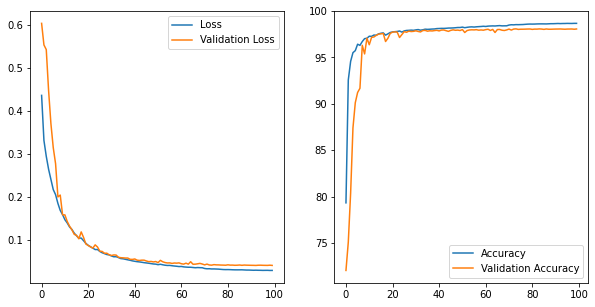

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

## Prediksi dari Validasiset

In [32]:
preds_val = model.predict(X_val)

2022-04-10 16:16:03.687331: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 147849216 exceeds 10% of free system memory.


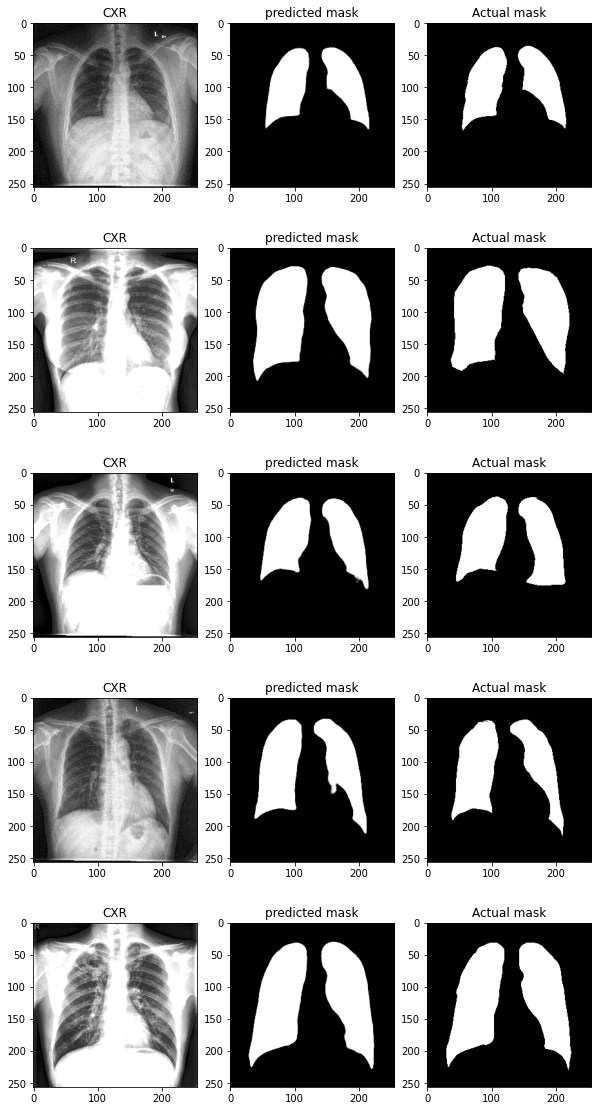

In [33]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for i in range(5):
    for j in range(3):
        if j == 0:
            axs[i, j].imshow(X_val[i + 10], cmap='gray')
            axs[i, j].set_title('CXR')
        elif j == 1:
            axs[i, j].imshow(preds_val[i + 10], cmap='gray')
            axs[i, j].set_title('predicted mask')
       
        elif j == 2:
            axs[i, j].imshow(Y_val[i + 10], cmap='gray')
            axs[i, j].set_title('Actual mask')

## Prediction dari testset

In [34]:
preds = model.predict(X_testNorm)

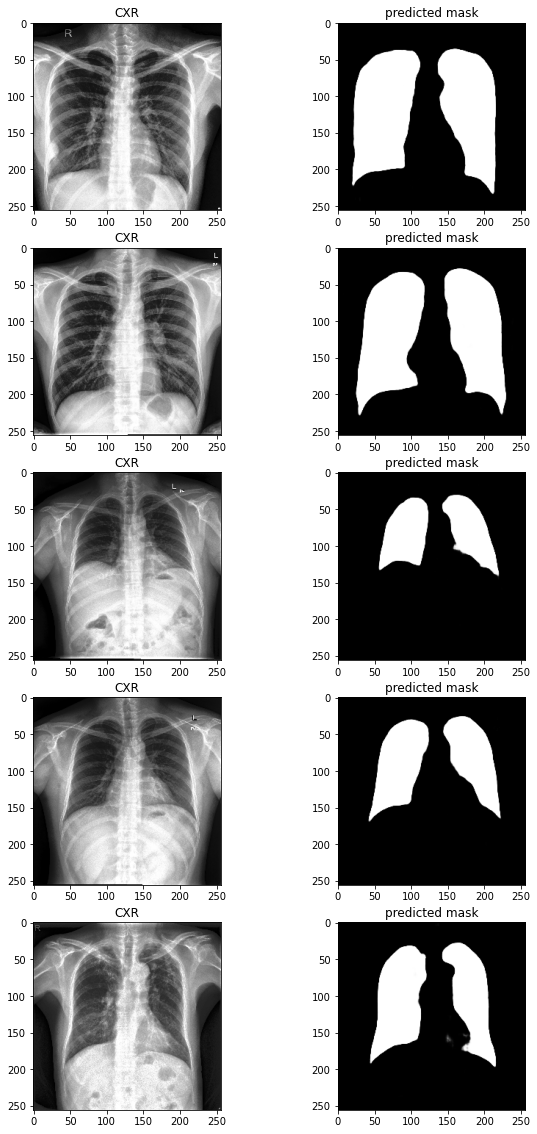

In [35]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i + 10], cmap='gray')
            axs[i, j].set_title('CXR')
        else:
            axs[i, j].imshow(preds[i + 10], cmap='gray')
            axs[i, j].set_title('predicted mask')